In [110]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import os
from matplotlib.animation import PillowWriter
from Tryba_Functions import scatter_with_subplots
import pandasql as psql
import math


# Data Import

In [ ]:
# create dataframe
time_tracking = pd.read_csv('time_tracking.csv')

# change date columns to datetime
time_tracking['datetime'] = time_tracking['datetime'].astype('datetime64[s]')

# Add days of week, week #, and year columns to time_tracking
time_tracking['day_of_week'] = time_tracking['datetime'].dt.day_name() 
time_tracking['year'] = time_tracking['datetime'].dt.year
time_tracking['week'] = time_tracking['datetime'].dt.isocalendar().week

# Exploratory Analysis

### Total Hours Separated by Activity

Let's begin with an overview of all productive hours tracked for different activities. 

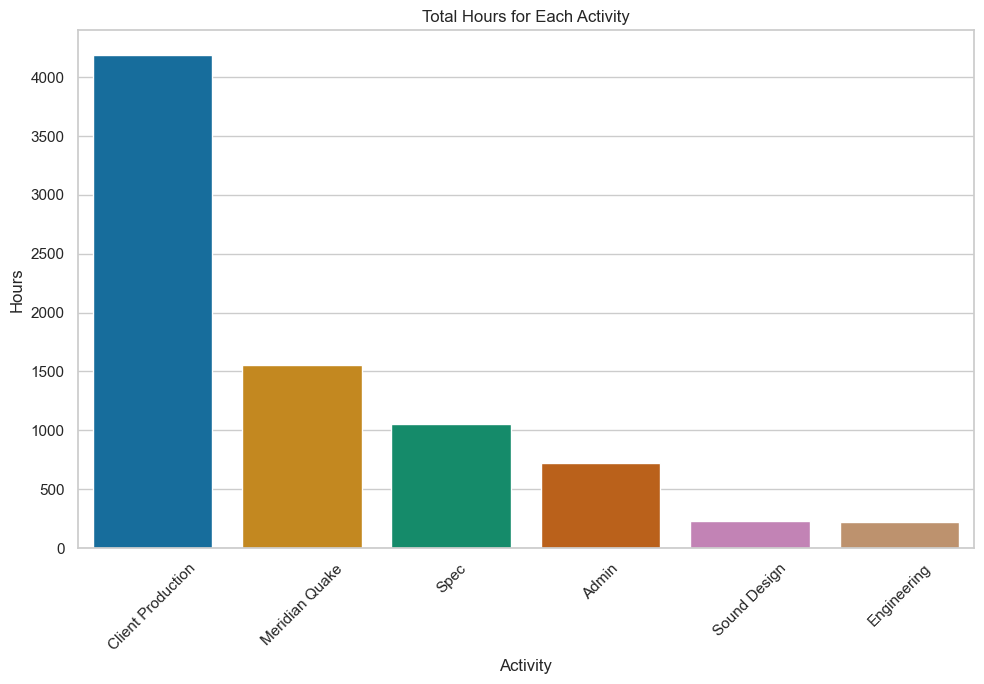

In [ ]:
# Filter business activities from tracking input
business_activities = ['Client Production', 'Meridian Quake', 'Spec', 'Admin', 'Sound Design', 'Engineering']
time_tracking_business = time_tracking[time_tracking['activity'].isin(business_activities)]

# sum total business hours by activity type
activity_total_hours = time_tracking_business.groupby('activity').hours.sum().reset_index(name='total_hours')
activity_total_hours = activity_total_hours.sort_values(by='total_hours', ascending=False)
#activity_total_hours.head(20)

# create figure
plt.figure(figsize=(10,7))
ax = plt.subplot()

# Set the style of seaborn
sns.set(style="whitegrid")

# Choose a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(activity_total_hours))

# Create the bar plot with the chosen palette
sns.barplot(x='activity', y='total_hours', data=activity_total_hours, palette=palette)
plt.xticks(rotation=45)
plt.xlabel('Activity')
plt.ylabel('Hours')
title = 'Total Hours for Each Activity'
plt.title(title)
plt.tight_layout()  # Ensures that labels and titles fit within the plot area
plt.savefig(os.path.join('Visualizations', title))
plt.show()

### How long is a focused productivity session via the Pomodoro Technique?

The average session length is 1.0 hours.


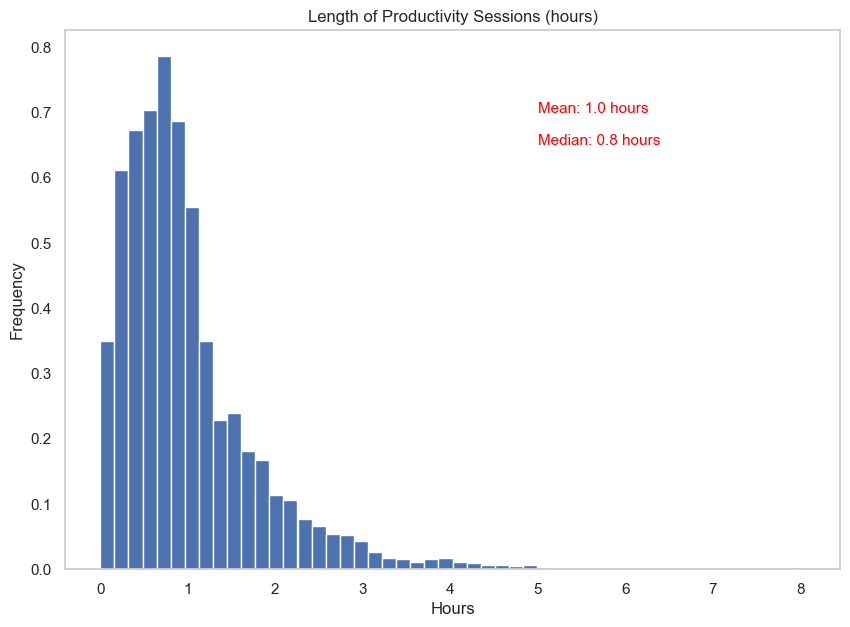

In [ ]:
# Determine average session length
average_session_length = round(time_tracking['hours'].mean(), 2)
median_session_length = round(time_tracking['hours'].median(), 2)
print(f'The average session length is {average_session_length} hours.')

# filter data by hours
column_data = time_tracking['hours']

# plot histogram
plt.figure(figsize=(10,7))
plt.hist(column_data, density=True, bins= 50)
title = 'Length of Productivity Sessions (hours)'
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title(title)
plt.grid(False)
plt.text(5,0.7, f'Mean: {average_session_length} hours', color='red', fontsize=11)
plt.text(5,0.65, f'Median: {median_session_length} hours', color='red', fontsize=11)
# save figure for reporting
plt.savefig(os.path.join('Visualizations', title))
plt.show()


### Productivity By Day of Week

In [ ]:
# List business activities
business_activities = ['Client Production', 'Meridian Quake', 'Spec', 'Admin', 'Sound Design', 'Engineering']

# Filter the years to be greater than 2016 and less than the current year
current_year = datetime.datetime.now().year
unique_years_temp = time_tracking[(time_tracking['activity'].isin(business_activities)) 
                                                & (time_tracking['year'] < current_year) 
                                                & (time_tracking['year'] > 2016)]

# Create list of years
years_list = unique_years_temp['year'].unique().tolist()
print(years_list)

[2017, 2018, 2019, 2020, 2021, 2022]


In [ ]:
time_tracking

,activity,datetime,hours,day_of_week,year,week
0,Client Production,2016-11-08 14:51:00,1.58,Tuesday,2016,45
1,Client Production,2016-11-08 16:40:00,1.53,Tuesday,2016,45
2,Client Production,2016-11-09 13:18:00,1.50,Wednesday,2016,45
3,Client Production,2016-11-09 15:18:00,1.55,Wednesday,2016,45
4,Client Production,2016-11-11 13:06:00,1.50,Friday,2016,45
...,...,...,...,...,...,...
8294,Edu Data Science,2023-09-18 18:25:00,0.52,Monday,2023,38
8295,Edu Data Science,2023-09-18 18:47:00,0.15,Monday,2023,38
8296,Client Production,2023-09-18 20:19:00,0.70,Monday,2023,38
8297,Client Production,2023-09-18 21:17:00,0.63,Monday,2023,38


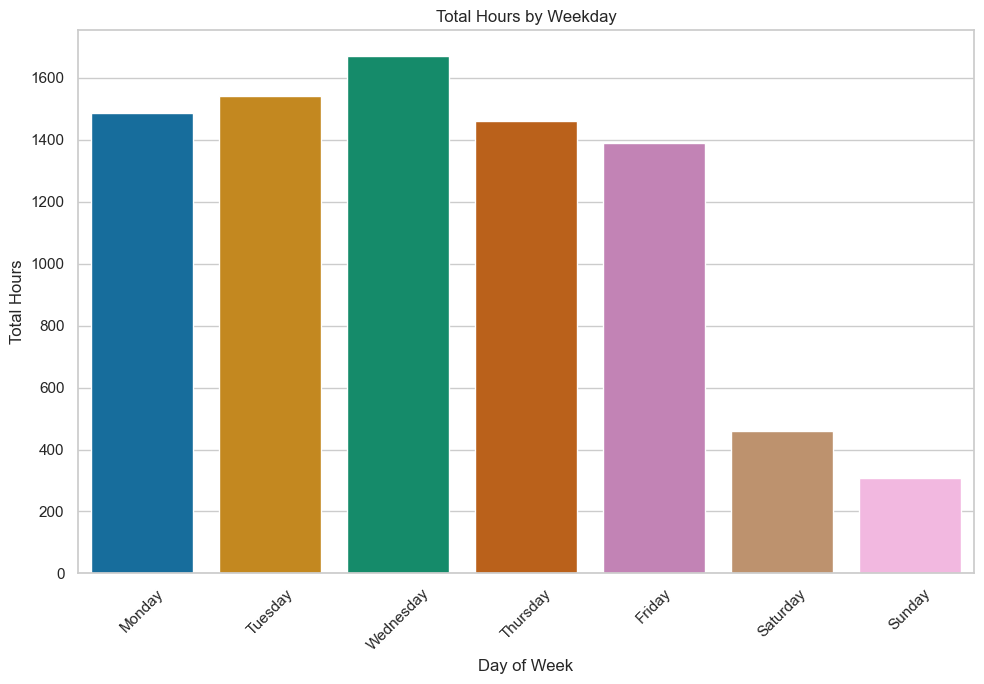

In [ ]:
# Are certain days of the week more productive?

# SQL: Sum hours by days of week and order by weekday
query = '''
    SELECT
        CASE
            WHEN day_of_week = 'Monday' THEN 1
            WHEN day_of_week = 'Tuesday' THEN 2
            WHEN day_of_week = 'Wednesday' THEN 3
            WHEN day_of_week = 'Thursday' THEN 4
            WHEN day_of_week = 'Friday' THEN 5
            WHEN day_of_week = 'Saturday' THEN 6
            WHEN day_of_week = 'Sunday' THEN 7
            ELSE 8 -- This handles any unexpected values
        END AS numeric_day,
        day_of_week,
        SUM(hours) AS total_hours
    FROM time_tracking
    GROUP BY 1
    ORDER BY 1 ASC;
    '''

# create dataframe from query
weekday_totals = psql.sqldf(query, locals())

plt.figure(figsize=(10,7))
ax = plt.subplot()

# Set the style of seaborn
sns.set(style="whitegrid")

# Choose a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(weekday_totals))

# Create the bar plot with the chosen palette
sns.barplot(x='day_of_week', y='total_hours', data=weekday_totals, palette=palette)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Total Hours')
title = 'Total Hours by Weekday'
plt.title(title)
plt.tight_layout()  # Ensures that labels and titles fit within the plot area
plt.savefig(os.path.join('Visualizations', title))
plt.show()


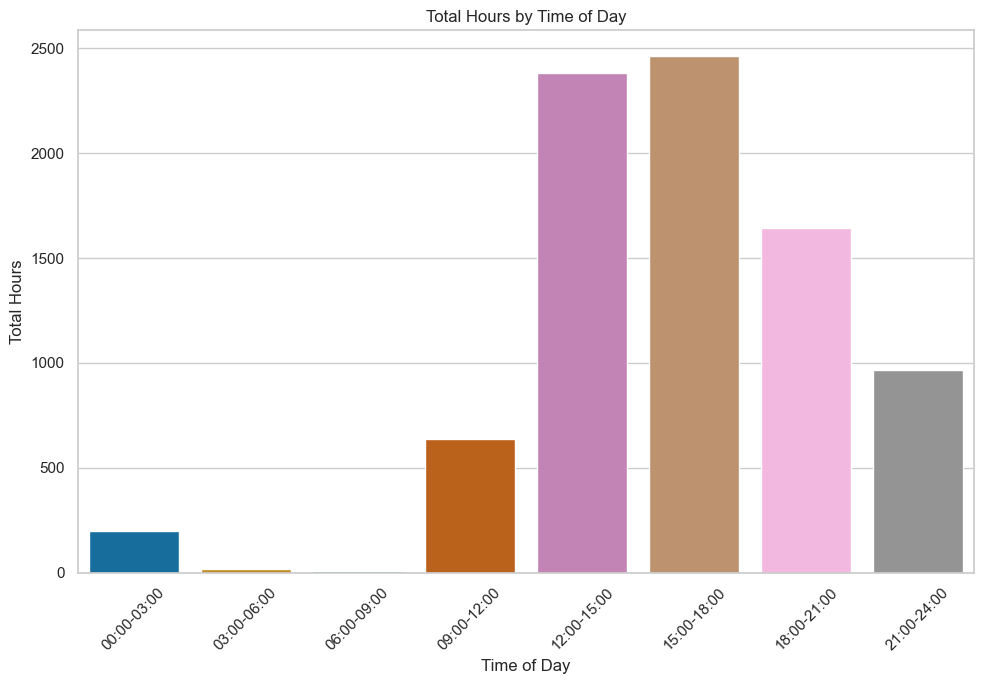

In [ ]:
# Are certain times of day when I am more productive?

# SQL: Sum hours by time of day and order by time of day
query = '''
    SELECT
        CASE
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 0 AND CAST(strftime('%H', datetime) AS INTEGER) < 3 THEN '00:00-03:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 3 AND CAST(strftime('%H', datetime) AS INTEGER) < 6 THEN '03:00-06:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 6 AND CAST(strftime('%H', datetime) AS INTEGER) < 9 THEN '06:00-09:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 9 AND CAST(strftime('%H', datetime) AS INTEGER) < 12 THEN '09:00-12:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 12 AND CAST(strftime('%H', datetime) AS INTEGER) < 15 THEN '12:00-15:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 15 AND CAST(strftime('%H', datetime) AS INTEGER) < 18 THEN '15:00-18:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 18 AND CAST(strftime('%H', datetime) AS INTEGER) < 21 THEN '18:00-21:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 21 AND CAST(strftime('%H', datetime) AS INTEGER) <= 23 THEN '21:00-24:00'
        END AS time_of_day,
        SUM(hours) as total_hours
    FROM time_tracking
    GROUP BY 1
    ORDER BY
        CASE
            WHEN time_of_day = '0-3' THEN 1
            WHEN time_of_day = '3-6' THEN 2
            WHEN time_of_day = '6-9' THEN 3
            WHEN time_of_day = '9-12' THEN 4
            WHEN time_of_day = '12-15' THEN 5
            WHEN time_of_day = '15-18' THEN 6
            WHEN time_of_day = '18-21' THEN 7
            WHEN time_of_day = '21-24' THEN 8
        END ASC;
    '''
# create dataframe from query
time_of_day = psql.sqldf(query, locals())

plt.figure(figsize=(10,7))
ax = plt.subplot()

# Set the style of seaborn
sns.set(style="whitegrid")

# Choose a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(time_of_day))

# Create the bar plot with the chosen palette
sns.barplot(x='time_of_day', y='total_hours', data=time_of_day, palette=palette)
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Total Hours')
title = 'Total Hours by Time of Day'
plt.title(title)
plt.tight_layout()  # Ensures that labels and titles fit within the plot area
plt.savefig(os.path.join('Visualizations', title))
plt.show()

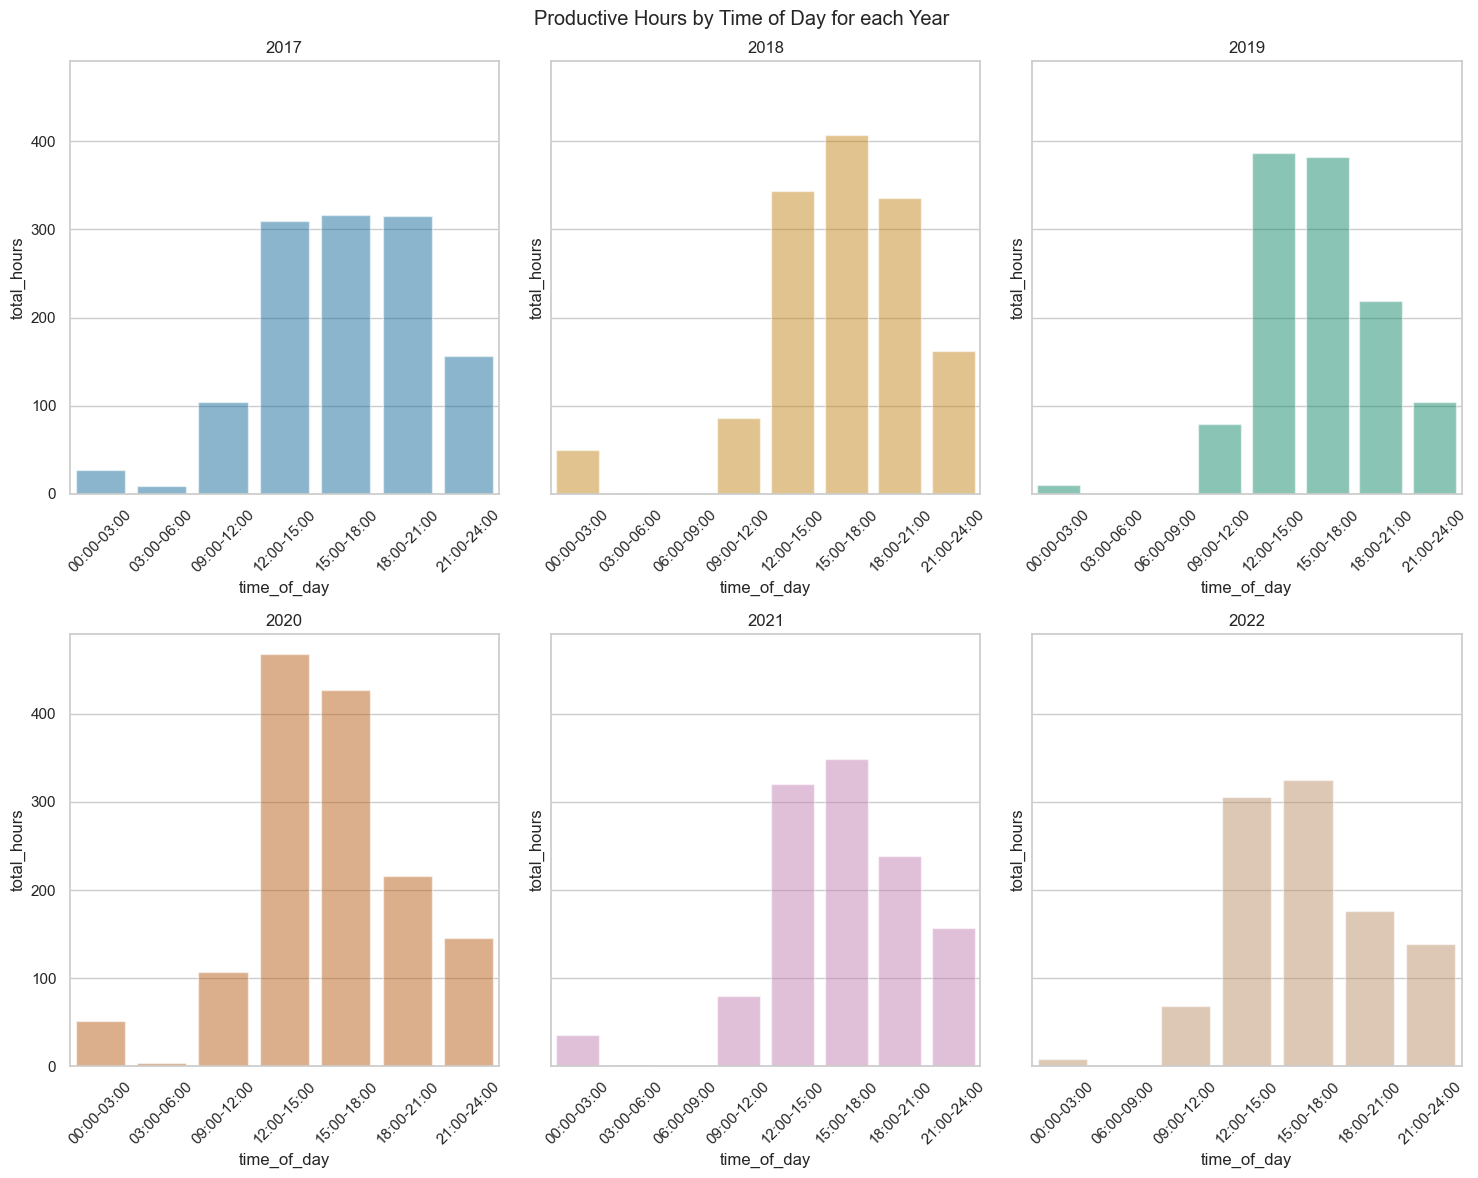

In [131]:
# How has my productivity by time of day changed over the years?

# get number of subplots
number_of_subplots = len(years_list)

# set the number of rows for the subplot
if number_of_subplots <= 4:
    rows = 1
elif number_of_subplots <= 8:
    rows = 2
elif number_of_subplots <= 12:
    rows = 3
else:
    print('Too many categories.')

# determine max number of columns
columns = math.ceil(number_of_subplots/rows)

# set subplot and palette indices for use in loop
subplot_index = 1
palette_index = 0

# create color palette
palette_list = sns.color_palette('colorblind', len(years_list))

# create subplots by iterating through 'categories_list' 
fig, ax = plt.subplots(rows, columns, figsize=(15,12), sharey=True)

for year in years_list:

    # filter dataframe by category
    query_data = time_tracking[time_tracking['year'] == year]

    # perform query
    query = '''
    SELECT
        CASE
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 0 AND CAST(strftime('%H', datetime) AS INTEGER) < 3 THEN '00:00-03:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 3 AND CAST(strftime('%H', datetime) AS INTEGER) < 6 THEN '03:00-06:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 6 AND CAST(strftime('%H', datetime) AS INTEGER) < 9 THEN '06:00-09:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 9 AND CAST(strftime('%H', datetime) AS INTEGER) < 12 THEN '09:00-12:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 12 AND CAST(strftime('%H', datetime) AS INTEGER) < 15 THEN '12:00-15:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 15 AND CAST(strftime('%H', datetime) AS INTEGER) < 18 THEN '15:00-18:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 18 AND CAST(strftime('%H', datetime) AS INTEGER) < 21 THEN '18:00-21:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 21 AND CAST(strftime('%H', datetime) AS INTEGER) <= 23 THEN '21:00-24:00'
        END AS time_of_day,
        SUM(hours) as total_hours
    FROM query_data
    GROUP BY 1
    ORDER BY
        CASE
            WHEN time_of_day = '0-3' THEN 1
            WHEN time_of_day = '3-6' THEN 2
            WHEN time_of_day = '6-9' THEN 3
            WHEN time_of_day = '9-12' THEN 4
            WHEN time_of_day = '12-15' THEN 5
            WHEN time_of_day = '15-18' THEN 6
            WHEN time_of_day = '18-21' THEN 7
            WHEN time_of_day = '21-24' THEN 8
        END ASC;
    '''
    # create dataframe from query
    plot_data = psql.sqldf(query, locals())

    # plot subplot
    plt.subplot(rows, columns, subplot_index)
    ax = sns.barplot(x = plot_data.iloc[:,0], y = plot_data.iloc[:,1], data = plot_data, color= palette_list[palette_index], alpha = 0.5)
    plt.title(year)
    plt.xticks(rotation=45)

    # advance plot indices
    subplot_index += 1
    palette_index += 1

# title and save overall figure
fig.suptitle('Productive Hours by Time of Day for each Year')
plt.tight_layout()
plt.savefig(os.path.join('Visualizations', 'Productive Hours by Time of Day for each Year'))
plt.show()

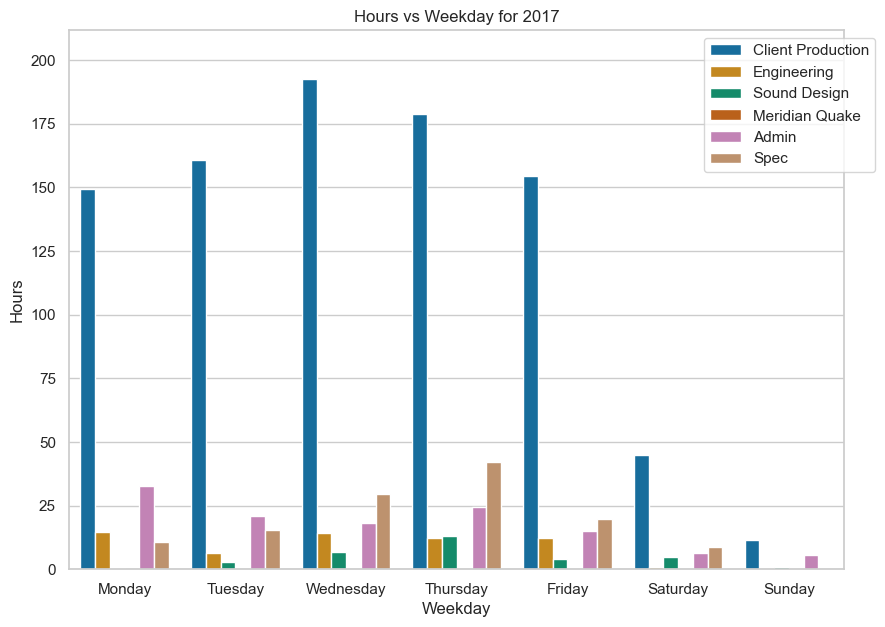

In [ ]:
# Create writer and meta data
metadata = dict(title='movie', artist ='Matthew Tryba')
writer = PillowWriter(fps=0.5, metadata=metadata)
title = 'Weekday Activity Changes by Year'
filepath = os.path.join('Visualizations', title + '.gif')

# Initialize the figure and axes outside of the loop
fig, ax = plt.subplots(figsize=(10,7))

with writer.saving(fig, filepath, 100):
    max_hours = 0

    for year in years_list:
        # Filter dataframe by year
        time_tracking_by_year = time_tracking[time_tracking['year'] == year]

         # Create a pivot table with day_of_week as index, activity as columns, and hours as values
        pivot_data = time_tracking_by_year.pivot_table(index='day_of_week', columns='activity', values='hours', aggfunc='sum')

        # Ensure all activities are present by re-indexing
        pivot_data = pivot_data.reindex(columns=business_activities, fill_value=0).reset_index()

        # Melt the data to get it back to long format for plotting
        plot_data = pivot_data.melt(id_vars='day_of_week', value_name='hours', var_name='activity')
        
        # Find the max hours for y axis
        if plot_data['hours'].max() > max_hours:
            max_hours = plot_data['hours'].max() * 1.1

        # Sort by days_of_week
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        plot_data['day_of_week'] = pd.Categorical(plot_data['day_of_week'], categories=days_order, ordered=True)
        plot_data = plot_data.sort_values('day_of_week')
        
        # Clear the current axes (necessary to avoid overlapping plots)
        ax.clear()
        
        # Create barplots for each year
        sns.barplot(x='day_of_week', y='hours', hue='activity', data=plot_data, ax=ax, palette='colorblind')
        ax.set_title(f'Hours vs Weekday for {year}')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
        ax.set_ylim(0, max_hours)
        ax.set_xlabel('Weekday')
        ax.set_ylabel('Hours')
        
        writer.grab_frame()
        plt.show()



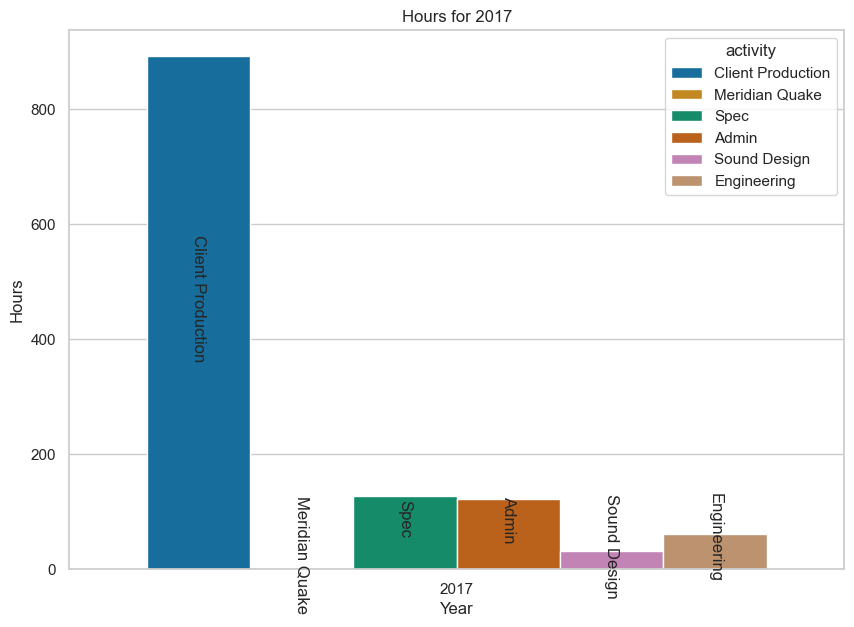

In [ ]:
# Create writer and meta data
metadata = dict(title='movie', artist ='Matthew Tryba')
writer = PillowWriter(fps=0.5, metadata=metadata)
title = 'Activity Changes by Year'
filepath = os.path.join('Visualizations', title + '.gif')

# Initialize the figure and axes outside of the loop
fig, ax = plt.subplots(figsize=(10,7))

with writer.saving(fig, filepath, 100):
    max_hours = 0

    for year in years_list:
        # Filter dataframe by year
        time_tracking_by_year = time_tracking[time_tracking['year'] == year]

         # Create a pivot table with day_of_week as index, activity as columns, and hours as values
        pivot_data = time_tracking_by_year.pivot_table(index='year', columns='activity', values='hours', aggfunc='sum')

        # Ensure all activities are present by reindexing
        pivot_data = pivot_data.reindex(columns=business_activities, fill_value=0).reset_index()
        
        # Melt the data to get it back to long format for plotting
        plot_data = pivot_data.melt(id_vars='year', value_name='hours', var_name='activity')
        
        # Find the max hours for y axis
        if plot_data['hours'].max() > max_hours:
            max_hours = plot_data['hours'].max() * 1.1
        
        # Clear the current axes (necessary to avoid overlapping plots)
        ax.clear()
        
        # Create barplots for each year
        sns.barplot(x='year', y='hours', hue='activity', data=plot_data, ax=ax, palette= 'colorblind')
        ax.set_title(f'Hours for {year}')
        #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
        #ax.set_ylim(0, max_hours)

        # Add hue values inside the bars
        for p, label in zip(ax.patches, plot_data['activity']):
            ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points', rotation=270)
        ax.set_xlabel('Year')
        ax.set_ylabel('Hours')
        writer.grab_frame()
        plt.show()
